In [3]:
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring

In [4]:
import multihash as mh
import hashlib as hl  

def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

def bit_string_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [5]:
import csv

filename = "nebula-peers.csv"

In [6]:
with open(filename, 'r') as file:
    nebula_peers = [line for line in csv.reader(file)]

In [9]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = []
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        self.neighbors.append(peer)
        self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)

In [29]:
peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers}

In [30]:
# define neighbor relationships
for p in peers:
    for n in peers[p].neighbors_ids:
        peers[p].addNeighbor(peers[n])

In [37]:
buckets=[[] for _ in range(257)]

for pid in peers:
    p=peers[pid]
    if p.alive:
        for i in range(len(p.buckets)):
            buckets[i].append(len(p.buckets[i]))


In [53]:
print(buckets[8])

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 13, 20, 20, 20, 19, 20, 20, 20, 20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 20, 20, 20, 

In [41]:
import matplotlib.pyplot as plt

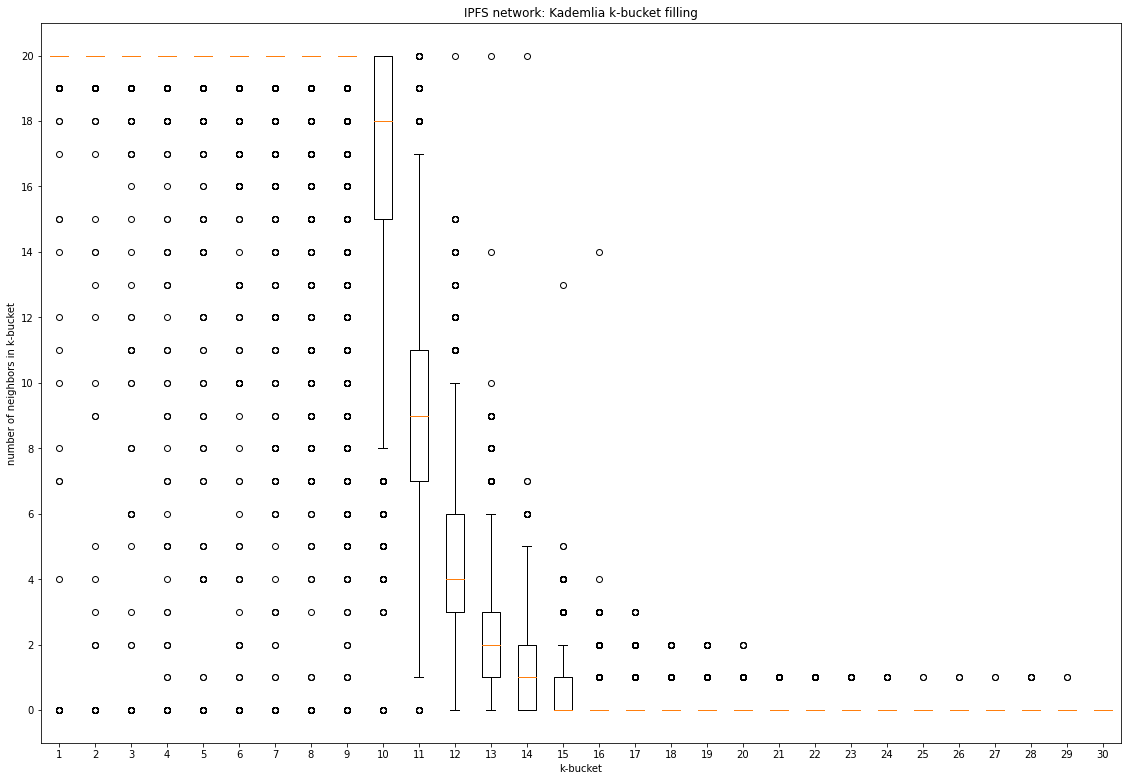

In [58]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))

plt.xlabel("k-bucket")
plt.ylabel("number of neighbors in k-bucket")

plt.title("IPFS network: Kademlia k-bucket filling")

_= ax.boxplot(buckets[:30])
 
# show plot
plt.show()

In [13]:
t = Trie()
for p in peers:
    t.add(bytes_to_bitstring(peers[p].key))